<a href="https://colab.research.google.com/github/andychiv/AWS_course/blob/main/Congressional_Analysis_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ul type="none">
  <li> Author: Andy Chiv, Shannon Weng </li>
  <li> Course: GSB 521-01 </li>
  <li> Date: February 9, 2023 </li>
</ul>

# Disparities in Six-Figure Households by Race and Political Affiliation in 2021

## Step 1: Introduction

The analysis on respective household income extremes in republican vs democratic districts demonstrated in GSB-S521 course on [January 26th, 2023 by Professor Piece](https://mybinder.org/v2/gh/jackalnom/congressional-analysis/HEAD?labpath=intro.ipynb) revealed that a larger proportion of households earning over \$200K per year are in Democratic districts compared to Republican districts. As a team with background from Cambodia and Taiwan, we found this finding very interesting and wanted to understand whether there are external factors contributing to the result. In this notebook, we are going to explore the impact of race on this relationship. To better reflect the effects of political affiliation and race on a wider segment of the population, we have changed the income threshold from \$200K to \$100K. Therefore, we will refer the term **six-figure** as an income that is higher than \$100K. Our goal is to gain a deeper understanding on how race may change a relationship between political affiliation and households with six-figure incomes.

### Data Source: 
We will be utilizing two sets of data: household income data and state-specific political affiliation data. 

- The household income data includes information from four different racial groups including **white, asian, black and hispanic households**, sourced from the **American Community Survey 2021** data set on [census.gov](https://www.census.gov) and the data of interests can be found in this [link](https://api.census.gov/data/2021/acs/acs1/variables.html).

    - **All race** – Household income in the past 12 months (in 2021 inflation-adjusted dollars): B19001_001E, B19001_014E, B19001_015E, B19001_016E, B19001_017E
    - **White Householder** – Household income in the past 12 months (in 2021 inflation-adjusted dollars): B19001A_001E, B19001A_014E, B19001A_015E, B19001A_016E, B19001A_017E
    - **Black or African American Householder** – Household income in the past 12 months (in 2021 inflation-adjusted dollars): B19001B_001E, B19001B_014E, B19001B_015E, B19001B_016E, B19001B_017E
    - **Asian Householder** – Household income in the past 12 months (in 2021 inflation-adjusted dollars)
    - **Hispanic or Latino Householder**– Household income in the past 12 months (in 2021 inflation-adjusted dollars): B19001D_001E, B19001I_014E, B19001I_015E, B19001I_016E, B19001I_017E
- The political affiliation data can be found on [house representative](https://www.house.gov/representatives). A CSV file containing party affiliation for each congressional district has already been created and it can be accessed through this link. http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv).




## Step 2: Hypothesis

Initially, we had an impression that race may play a significant role in the relationship between political affiliation and the proportion of households that earn at least \$100K since there are many racial groups in the United States. In other words, we want to find out if the households earning six figures for both political affiliation also depends on race. So, we began this analysis by hypothesizing as follows:

- Ho: There is no interaction effect between Race and Political Affililation on the proportion of households with incomes higher than \$100K. 
- Ha: There is an interaction effect between Race and Political Affililation on the proportion of households with incomes higher than \$100K. 


## Step 3: Data Extraction & Wrangling

This step focuses on data extraction and data wrangling on the data from the American Community Survey 2021. 

1. Import necessay packages
2. Extract the data for househoulds whose income are at least \$100,000 from the cencus website.  We also extract similar data but only for white, asian, hispanic and black households whose income are at least \$100,000.
3. Performing data cleaning and transforming variables into their desired data types.
4. Extract the party affiliation for each congressional district

**Desired Variable Description**:

- `State`: U.S. States
- `District Number:` Congressional district number
- `Party`: Political Affiliation: Democratic or Republican
- `% of White Household over \$100K:` the number of white households earning over \$100K / the total number of white households in each congressional district
- `% of Asian Household over \$100K:` the number of Asian households earning over \$100K / the total number of Asian households in each congressional district
- `% of Black Household over \$100K:` the number of Black households earning over \$100K / the total number of black households in each congressional district
- `% of Hispa Household over \$100K:` the number of Hispanic households earning over \$100K / the total number of Hispanic households in each congressional district

In [2]:
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import plotly.express as px
import seaborn as sns

In [3]:
# Let's begin by having url inputs from census website: 
url_district = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_014E,B19001_015E,B19001_016E,B19001_017E&for=congressional%20district:*"

# open the url
response = urlopen(url_district)

# Parse the json data and load the dataset
data_json = json.loads(response.read())
data_json.pop(0)

# Convert the json data into a dataframe
state_df = pd.DataFrame(data_json)

# Convert all columns into numerical value
cols = [1, 2, 3, 4, 5, 6, 7]
state_df[cols] = state_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# Find the total number of households that have 100K+ incomes
state_df["All_100K+"] = state_df.iloc[:, [2, 3, 4, 5]].sum(axis=1)

# Extract State name
state_df[['District', 'State']] = state_df[0].str.split(',', expand=True)

# Rename some columns
state_df.rename(columns={1: 'Total_Households', 6: 'State Code', 7: 'District Number'}, inplace=True)

# Let's just keep the columns we need
state_df = state_df[['Total_Households', 'All_100K+', "District Number", 'State Code', 'State']]

state_df.head()

,Total_Households,All_100K+,District Number,State Code,State
0,289474,93753,10,26,Michigan
1,299804,64821,4,28,Mississippi
2,278057,73075,14,26,Michigan
3,306685,69324,1,26,Michigan
4,285554,65682,3,28,Mississippi


In [4]:
# api url that contains household incomes for white, asian, black and hispa
url_white = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001A_001E,B19001A_014E,B19001A_015E,B19001A_016E,B19001A_017E&for=congressional%20district:*"
url_asian = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001D_001E,B19001D_014E,B19001D_015E,B19001D_016E,B19001D_017E&for=congressional%20district:*"
url_black = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001B_001E,B19001B_014E,B19001B_015E,B19001B_016E,B19001B_017E&for=congressional%20district:*"
url_hispa = "https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001I_001E,B19001I_014E,B19001I_015E,B19001I_016E,B19001I_017E&for=congressional%20district:*"

# open the url for all races
response_white = urlopen(url_white)
response_asian = urlopen(url_asian)
response_black = urlopen(url_black)
response_hispa = urlopen(url_hispa)

# Parse the json data and load the dataset and remove the first column
df_json_white = json.loads(response_white.read())
df_json_asian = json.loads(response_asian.read())
df_json_black = json.loads(response_black.read())
df_json_hispa = json.loads(response_hispa.read())

# Remove the head name so that we insert a new name and update variable type
df_json_white.pop(0)
df_json_asian.pop(0)
df_json_black.pop(0)
df_json_hispa.pop(0)

# Covert the json data into a dataframe 
df_white = pd.DataFrame(df_json_white) 
df_asian = pd.DataFrame(df_json_asian) 
df_black = pd.DataFrame(df_json_black) 
df_hispa = pd.DataFrame(df_json_hispa) 

# Covert all columns into numerical values
cols = [1, 2, 3, 4, 5, 6, 7]
df_white[cols] = df_white[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_asian[cols] = df_asian[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_black[cols] = df_black[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_hispa[cols] = df_hispa[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# Find the total number of households that have 100K+ incomes using sum function
df_white["White 100K+"] = df_white.iloc[:, [2, 3, 4, 5]].sum(axis=1)
df_asian["Asian 100K+"] = df_asian.iloc[:, [2, 3, 4, 5]].sum(axis=1)
df_black["Black 100K+"] = df_black.iloc[:, [2, 3, 4, 5]].sum(axis=1)
df_hispa["Hispa 100K+"] = df_hispa.iloc[:, [2, 3, 4, 5]].sum(axis=1)


# Extract district and state name
df_white[['District', 'State']] = df_white[0].str.split(',', expand=True)
df_asian[['District', 'State']] = df_asian[0].str.split(',', expand=True)
df_black[['District', 'State']] = df_black[0].str.split(',', expand=True)
df_hispa[['District', 'State']] = df_hispa[0].str.split(',', expand=True)

# Rename some columns
df_white.rename(columns={1: 'Total White Households', 6: 'State Code', 7: 'District Number'}, inplace=True)
df_asian.rename(columns={1: 'Total Asian Households', 6: 'State Code', 7: 'District Number'}, inplace=True)
df_black.rename(columns={1: 'Total Black Households', 6: 'State Code', 7: 'District Number'}, inplace=True)
df_hispa.rename(columns={1: 'Total Hispa Households', 6: 'State Code', 7: 'District Number'}, inplace=True)

# Selecting only the columns we want
df_white = df_white[['State', 'State Code', 'District Number', 'Total White Households', 'White 100K+']]
df_asian = df_asian[['State', 'State Code', 'District Number', 'Total Asian Households', 'Asian 100K+']]
df_black = df_black[['State', 'State Code', 'District Number', 'Total Black Households', 'Black 100K+']]
df_hispa = df_hispa[['State', 'State Code', 'District Number', 'Total Hispa Households', 'Hispa 100K+']]

# Convert some columns into integer
df_white = df_white.astype({"State Code": "Int64", "District Number": "Int64"})
df_asian = df_asian.astype({"State Code": "Int64", "District Number": "Int64"})
df_black = df_black.astype({"State Code": "Int64", "District Number": "Int64"})
df_hispa = df_hispa.astype({"State Code": "Int64", "District Number": "Int64"})

# Normalizing the proportion of household incomes that makes at least $100K by 
# the number of household incomes that make at least $100K divided that the total population of their respective race for each congressional district
df_white["% of White Household over $100K"] = df_white["White 100K+"]/df_white["Total White Households"]*100
df_asian["% of Asian Household over $100K"] = df_asian["Asian 100K+"]/df_asian["Total Asian Households"]*100
df_black["% of Black Household over $100K"] = df_black["Black 100K+"]/df_black["Total Black Households"]*100
df_hispa["% of Hispa Household over $100K"] = df_hispa["Hispa 100K+"]/df_hispa["Total Hispa Households"]*100

# Replace any NA value to 0
df_white.fillna(0, inplace = True)
df_asian.fillna(0, inplace = True)
df_black.fillna(0, inplace = True)
df_hispa.fillna(0, inplace = True)

Viewing White Households Dataset

In [5]:
df_white.head()

,State,State Code,District Number,Total White Households,White 100K+,% of White Household over $100K
0,Michigan,26,10,259422,84963,32.750885
1,Mississippi,28,4,210479,53135,25.244799
2,Michigan,26,14,97662,38375,39.293686
3,Michigan,26,1,283975,64421,22.685448
4,Mississippi,28,3,173837,51619,29.693909


Viewing Asian Households Dataset

In [6]:
df_asian.head()

,State,State Code,District Number,Total Asian Households,Asian 100K+,% of Asian Household over $100K
0,Alaska,2,0,12509.0,4771.0,38.140539
1,Arizona,4,2,9314.0,2753.0,29.557655
2,Arizona,4,3,4498.0,1310.0,29.124055
3,Arizona,4,5,16697.0,9858.0,59.040546
4,Arizona,4,6,15726.0,9539.0,60.657510


Viewing Black Households Dataset

In [7]:
df_black.head()

,State,State Code,District Number,Total Black Households,Black 100K+,% of Black Household over $100K
0,Alabama,1,1,77859.0,6964.0,8.944374
1,Alabama,1,2,82802.0,8794.0,10.620516
2,Alabama,1,3,70386.0,9181.0,13.043787
3,Alabama,1,4,17908.0,1850.0,10.330579
4,Alabama,1,5,50691.0,11738.0,23.155984


Viewing Hispanic Households Dataset

In [8]:
df_hispa

,State,State Code,District Number,Total Hispa Households,Hispa 100K+,% of Hispa Household over $100K
0,Michigan,26,10,8507.0,2138.0,25.132244
1,Mississippi,28,4,11211.0,1495.0,13.335117
2,Michigan,26,14,9931.0,1995.0,20.088611
3,Michigan,26,1,4429.0,1182.0,26.687740
4,Mississippi,28,3,0.0,0.0,0.000000
...,...,...,...,...,...,...
432,Missouri,29,6,9497.0,3099.0,32.631357
433,Missouri,29,7,13452.0,2351.0,17.476955
434,Michigan,26,5,10764.0,1658.0,15.403196
435,Michigan,26,6,12648.0,3021.0,23.885199


Party Affiliation For Each Congressional District

In [9]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', 'district number']]
party_df.rename(columns={'district number': 'District Number'}, inplace = True)

# State abbreviation dictionary
states = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL",
    "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA",
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
    "District of Columbia": "DC","American Samoa": "AS","Guam": "GU","Northern Mariana Islands": "MP","Puerto Rico": "PR","United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI",
}


# Update the state abbreviation 
party_df['State'] = party_df['State'].map(lambda x: states.get(x, x))
party_df.head(5)

,State,Party,District Number
0,LA,R,5
1,NC,D,12
2,AL,R,4
3,CA,D,31
4,GA,R,12


# Step 4: Merging the Dataset

We have 5 clean datasets, of all which are ready to be merged together. 
We will merge the state_df datasets with the other 4 race-only datasets using State, State code and District Number to join.

In [10]:
# Join all the dataframe from 4 races: White, Asian, Black and Hispanic 
df_race = state_df.merge(
    df_white, on=["State", "State Code", "District Number"]).merge(
        df_asian , on=["State", "State Code", "District Number"]).merge(
            df_black, on=["State", "State Code", "District Number"]).merge(
                df_hispa, on=["State", "State Code", "District Number"])
            
# Select only desired columns
cols = ["State", "District Number", 
        "% of White Household over $100K", 
        "% of Asian Household over $100K", 
        "% of Black Household over $100K", 
        "% of Hispa Household over $100K"]

df_race['State'] = df_race['State'].str.strip()
df_race['State'] = df_race['State'].map(lambda x: states.get(x, x))
df_race = df_race[cols]
df_race.fillna(0, inplace=True)


# Merge the party_df and df_race 
df_merge = df_race.merge(party_df, on = ["District Number", "State"])
df_merge.head()

,State,District Number,% of White Household over $100K,% of Asian Household over $100K,% of Black Household over $100K,% of Hispa Household over $100K,Party
0,MI,10,32.750885,0.000000,24.923382,25.132244,R
1,MS,4,25.244799,0.000000,10.630979,13.335117,R
2,MI,14,39.293686,41.126706,17.408952,20.088611,D
3,MI,1,22.685448,0.000000,0.000000,26.687740,R
4,MS,3,29.693909,0.000000,11.020598,0.000000,R


# Step 5: Reshaping the Data

In [11]:
# Select only important columns
col_vars = [ 
        "% of White Household over $100K", 
        "% of Asian Household over $100K", 
        "% of Black Household over $100K", 
        "% of Hispa Household over $100K", 
        "Party"]

# Put them into a new dataframe and perform pivot long
df_final = df_merge[col_vars]
df_final = df_final.melt(id_vars='Party', var_name='Race',value_name='Proportion')

race_update = {"% of White Household over $100K": "White", 
               "% of Asian Household over $100K": "Asian", 
               "% of Black Household over $100K": "Black", 
               "% of Hispa Household over $100K": "Hispanic"}

# rename the columns 
df_final['Race'] = df_final['Race'].map(lambda x: race_update.get(x, x))
df_final["Party"].value_counts()       

D    932
R    804
L      4
Name: Party, dtype: int64

The Libertarian party has a very small sample size, so we decided to remove them from our dataset. 

In [12]:
# Filter the dataframe to only include the 'D' and 'R' parties
df_final2 = df_final[df_final['Party'].isin(['D', 'R'])]

# Rename the party to its full name
df_final2.loc[df_final2['Party'] == 'D', 'Party'] = 'Democratic'
df_final2.loc[df_final2['Party'] == 'R', 'Party'] = 'Republic'
df_final2["Party"].value_counts()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Democratic    932
Republic      804
Name: Party, dtype: int64

View our final dataset that contains only 3 variables

In [13]:
df_final.head()

,Party,Race,Proportion
0,R,White,32.750885
1,R,White,25.244799
2,D,White,39.293686
3,R,White,22.685448
4,R,White,29.693909


# Step 6: Data Exploration with Visualization

### Boxplot showing the Proportion of Six-Figure Households VS Race

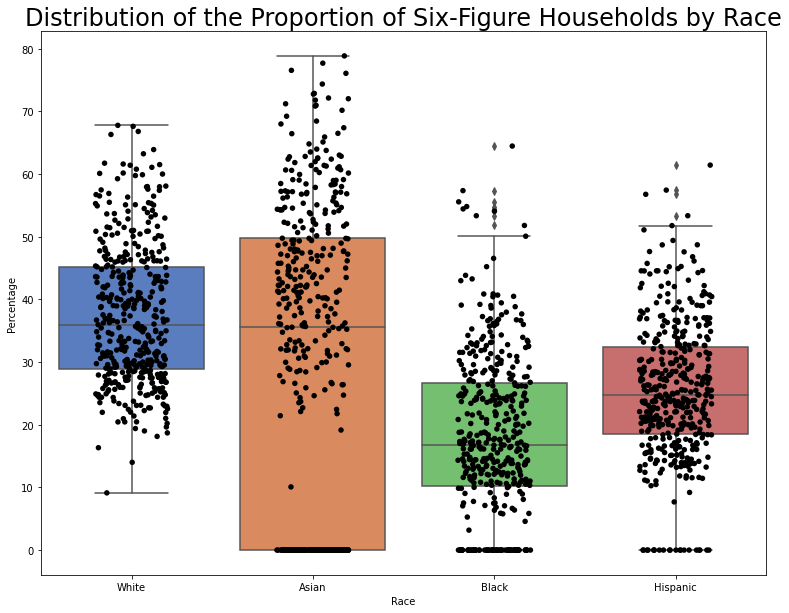

In [14]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.set(font_scale=2)


ax = sns.boxplot(x='Race', y='Proportion', data=df_final2, ax=ax, palette="muted")
ax = sns.stripplot(x='Race', y='Proportion', data=df_final2, color = "black", jitter=0.2, size=5.5, ax=ax)

# Add a title and labels to the x and y axis
plt.title("Distribution of the Proportion of Six-Figure Households by Race")
plt.xlabel("Race")
plt.ylabel("Percentage")

plt.show()

This plot depicts the distribution of the proportion of households with six-figure incomes across different races. By using a boxplot and scatterplot in combination, we can get a more comprehensive understanding of the data. The boxplot displays the median, quartiles, and outliers of the data, while the scatterplot shows each individual observation.

From the plot, we can see that white household has the highest median proportion of earning six-figure, while the Asian household has the largest range of values as indicated by the quartiles. On the other hand, black and Hispanic households have a higher number of outliers, indicating a greater spread in the data. 

An interesting observation is that when we look at the scatterplot points, it appears that the Asian Household has higher individual performances compared to white households. However, it is important to note that there is a significant amount of missing data for the Asian, black, and Hispanic households, which may be due to the fact that some congressional districts do not have six-figure household incomes for these races, causing the value to be set to zero.

### Violin Plot Showing the Effect of Race and Political Affiliation on the Proportion of Six-Figure Households

In [39]:
# Use group by
df_final3 = df_final2.groupby(["Race", "Party"]).mean()
# Round the number by 2 decimal
df_final3["Proportion"] = round(df_final3["Proportion"], 2)

# Pivoting data to aggregate by Party
pivot_df = df_final3.pivot_table(index='Party', columns='Race', values= ['Proportion'])
pivot_df

Proportion                       
Race            Asian  Black Hispanic  White
Party                                       
Democratic      39.72  20.68    28.48  41.68
Republic        18.55  14.83    21.64  32.60

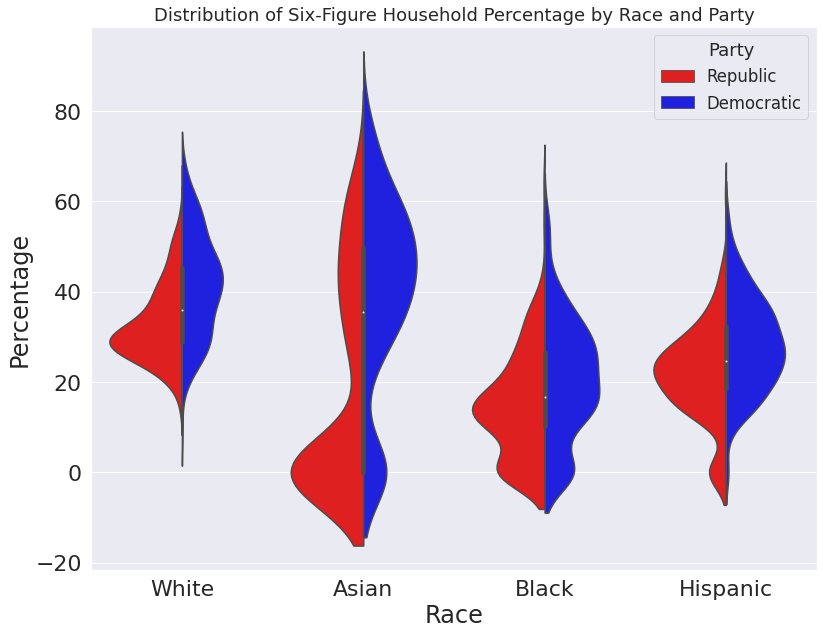

In [15]:
# Create the violin plot
fig, ax = plt.subplots(figsize=(13, 10))
sns.set(font_scale=1.5)

cus_palette = ["red", "blue"]
#df_final2['Party'] = df_final['Party'].map({'R': 'Republic', 'D': 'Democratic'})
sns.violinplot(x="Race", y="Proportion", hue="Party", data=df_final2, split=True, palette = cus_palette)

# Add a title and labels to the x and y axis
plt.title("Distribution of Six-Figure Household Percentage by Race and Party")
plt.xlabel("Race")
plt.ylabel("Percentage")

# Show the plot
plt.show()

We can observe that there are many interesting patterns after applying **Race** into the violin plots. For simplicity, we will refer the term **"response"** as **the proportion of six-figure households** in this context. 
1. For White household, the distribution of response variable in Republican districts are right-skewed compared to a more normal distribution in Democratic districts. This signifies that a majority of white households in Democratic Districts tend to have a higher proportion of six-figure compared to Republican districts. 
2. For Asian households, both parties have two-humped distributions of the response. The lower ends can be explained that there are many congressional districts where Asian households neither reside nor earn at least \$100K. Both upper humps have a normal distribution with the mean approximately 45%. What's interesting here is that Asian households earning at least \$100K are more concentrated in Democratic districts as opposed to Republican districts, which is shown by the density of that upper hump.   
3. For Black Households, the lower humps may have similar interpretation as Asian households. It appears that the proportion of those earning at least \$100K is slightly more concentrated in democratic districts.
3. For Hispanic Households, we can also see that the distribution for both parties are almost identical with normal curve. That tells us that regardless that of what party districts hispanic holdholds are from, there are more likely to have similar proportion of those who earns at least $100K. 

## Step 7: Statistical Analysis

After observing the boxplot and violin plot, we can clearly see that **Race** does makes a difference in the relationship between political affiliation and the proportion of six-figure households. In order to understand the effect of race, we also consider investigating the interaction effect between party affililation and race by using ANOVA. The variables of interests are as follows:

- *Categorical variable* - **Race** has 4 levels: White, Asian, Black and Hispanic
- *Categorical variable* - **Political Affiliation** has 2 levels: Democratic and Republican
- *Interaction Variable*: **Race * Political Affiliation**
- *Quantitative response variable*: the proportion of households with incomes higher than \$100K. 

#### Hypothesis:
- Ho: There is no interaction effect between Race and Political Affililation on the proportion of households with incomes higher than \$100K. 
- Ha: There is an interaction effect between Race and Political Affililation on the proportion of households with incomes higher than \$100K. 


Let's take a look at interaction plot before running the ANOVA test. 

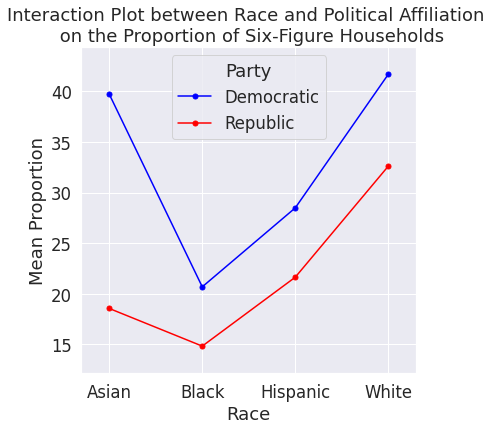

In [24]:
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x = df_final2["Race"], 
    trace = df_final2["Party"], 
    response = df_final2["Proportion"], 
    colors = ["blue", "red"],
    ms = 10, 
    ax = ax
)

# Label the graph
plt.title("Interaction Plot between Race and Political Affiliation \n on the Proportion of Six-Figure Households")
plt.xlabel("Race")
plt.ylabel("Mean Proportion")

# display the plot
plt.show()

Observe that because the blue and red lines are not parallel, indicating a presence of interaction effect. So if we are to perform the interaction test, we will be seeing the significance of that effect. So we can say that **Race** modifies the effect of **Party** on the proportion of six-figure households.

In [17]:
# import statistical package
import statsmodels.api as sm 
from statsmodels.formula.api import ols 

# Perform two-way ANOVA
model = ols('Proportion ~ C(Race) + C(Party) + C(Race):C(Party)', data = df_final2).fit()
sm.stats.anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(Race),87144.598612,3.0,134.077526,4.333539e-78
C(Party),49763.412170,1.0,229.692555,8.262028e-49
C(Race):C(Party),16242.108490,3.0,24.989520,7.944117e-16
Residual,374375.112454,1728.0,NaN,NaN


The table above is the ANOVA summary explaining how each explanatory variable has an impact on the proportion of households with incomes higher than \$100K.Based on the table, **Race** and **Party** have p-value less than 0.05, which explains that both factors have a statistically significant effect on the proportion of households that make at least \$100K. We also continue to observe the interaction effect of **Race*Party** having a p-value less than 0.05. It tells us that the association between party affiliation and the proportion of households with at least \$100K also depends on **Race**. 

**Conclusion:** With a small p-value, we have a strong evidence to **reject the null hypothesis** and conclude that there is a significant interaction between race and party affiliation on the proportion of households making at least \$100K.

## Step 8: Key takeaways

- The visualization and statistical analysis have provided us more evidence to support our initial hypothesis and we can conclude that there exist disparities in Six-Figure Households due to race and political affiliation. In general, the 4 racial households who make six-figure tends to live in Democratic districts compared to Republican districts. 
- Assuming we would like to understand which race and political party has the highest average proportion earning six figures, we need to further apply more tests such as Post-hoc tests because it will tell us which means are different without having prior hypothesis. 